In [1]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('/home/husein/space/mnist')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/husein/space/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /home/husein/space/mnist/train-labels-idx1-ubyte.gz
Extracting /home/husein/space/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/husein/space/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def convolutionize(x, conv_w, h = 1):
    return tf.nn.conv2d(input = x, filter = conv_w, strides = [1, h, h, 1], padding = 'SAME')

def pooling(wx):
    return tf.nn.max_pool(wx, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def create_network(X, scope='conv',reuse=False):
    with tf.variable_scope(scope,reuse=reuse):
        w1 = tf.Variable(tf.random_normal([3, 3, 1, 2], stddev = 0.5))
        b1 = tf.Variable(tf.zeros(shape = [2]))
        w2 = tf.Variable(tf.random_normal([3, 3, 2, 4], stddev = 0.5))
        b2 = tf.Variable(tf.zeros(shape = [4]))
        w3 = tf.Variable(tf.random_normal([3, 3, 4, 8], stddev = 0.5))
        b3 = tf.Variable(tf.zeros(shape = [8]))
        w4 = tf.Variable(tf.random_normal([128, 2], stddev = 0.5))
        b4 = tf.Variable(tf.zeros(shape = [2]))

        conv1 = pooling(tf.nn.relu(convolutionize(X, w1) + b1))
        conv2 = pooling(tf.nn.relu(convolutionize(conv1, w2) + b2))
        conv3 = pooling(tf.nn.relu(convolutionize(conv2, w3) + b3))
        conv3 = tf.reshape(conv3, [-1, 128])
        return tf.matmul(conv3, w4) + b4

class Siamese:
    def __init__(self):
        self.X1 = tf.placeholder(tf.float32, (None, 28, 28, 1))
        self.X2 = tf.placeholder(tf.float32, (None, 28, 28, 1))
        self.Y = tf.placeholder(tf.float32, [None])
        self.output1 = create_network(self.X1)
        self.output2 = create_network(self.X2,reuse=True)
        labels_true = self.Y
        labels_false = tf.subtract(1.0, self.Y)
        eucd = tf.pow(tf.subtract(self.output1, self.output2), 2)
        eucd = tf.reduce_sum(eucd, 1)
        eucd = tf.sqrt(eucd + 1e-6)
        margin = tf.constant(5.0)
        pos = tf.multiply(labels_true, eucd)
        neg = tf.multiply(labels_false, tf.pow(tf.maximum(tf.subtract(margin, eucd), 0), 2))
        self.cost = tf.reduce_mean(tf.add(pos, neg))
        self.optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(self.cost)

In [4]:
sess = tf.InteractiveSession()
model = Siamese()
sess.run(tf.global_variables_initializer())

In [5]:
BATCH_SIZE = 128
EPOCH = 10000

for i in range(EPOCH):
    batch_x1, batch_y1 = mnist.train.next_batch(BATCH_SIZE)
    batch_x2, batch_y2 = mnist.train.next_batch(BATCH_SIZE)
    batch_y = (batch_y1 == batch_y2).astype('float')
    _, loss = sess.run([model.optimizer, model.cost], feed_dict={model.X1: batch_x1.reshape((-1,28,28,1)),
                                                                 model.X2: batch_x2.reshape((-1,28,28,1)),
                                                                 model.Y: batch_y})
    if np.isnan(loss):
        print('Model diverged with loss = NaN')
        quit()
    
    if (i+1) % 1000 == 0:
        print('epoch %d, loss %f'%(i+1,loss))

epoch 1000, loss 0.392009
epoch 2000, loss 0.622059
epoch 3000, loss 0.316901
epoch 4000, loss 0.507249
epoch 5000, loss 0.507095
epoch 6000, loss 0.585954
epoch 7000, loss 0.697705
epoch 8000, loss 0.431247
epoch 9000, loss 0.543710
epoch 10000, loss 0.388889


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

In [7]:
embed = model.output1.eval({model.X1: mnist.test.images.reshape((-1,28,28,1))})

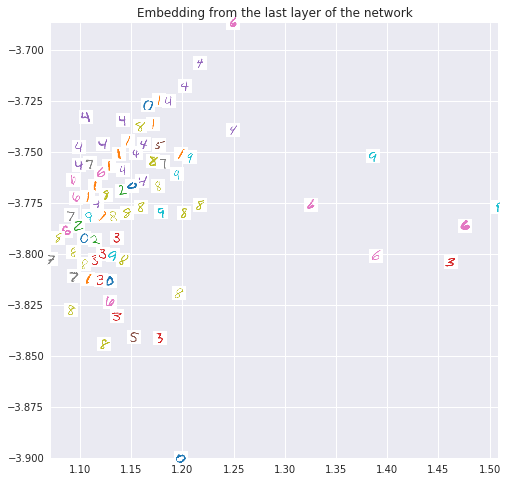

In [8]:
x_test = mnist.test.images.reshape([-1, 28, 28])
y_test = mnist.test.labels

ax_min = np.min(embed,0)
ax_max = np.max(embed,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
colormap = plt.get_cmap('tab10')
shown_images = np.array([[1., 1.]])
for i in range(embed.shape[0]):
    dist = np.sum((embed[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [embed[i]]]
    patch_to_color = np.expand_dims(x_test[i], -1)
    patch_to_color = np.tile(patch_to_color, (1, 1, 3))
    patch_to_color = (1-patch_to_color) * (1,1,1) + patch_to_color * colormap(y_test[i]/10.)[:3]
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(patch_to_color, zoom=0.5, cmap=plt.cm.gray_r),
        xy=embed[i], frameon=False
    )
    ax.add_artist(imagebox)

plt.axis([ax_min[0], ax_max[0], ax_min[1], ax_max[1]])
plt.title('Embedding from the last layer of the network')
plt.show()